2018.10.27: Multiple states: Time series

In [1]:
import sys,os
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setting parameter:
np.random.seed(1)

n = 10 # number of positions
m = 2 # number of values at each position
l = 1000 # number of samples

g = 1.

In [3]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

i1tab,i2tab = itab(n,m)

In [4]:
# generate coupling matrix w0:
def generate_coupling(n,m,g):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    
    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[i1:i2,:] = w[i1:i2,:] - w[i1:i2,:].mean(axis=0)            
    
    return w

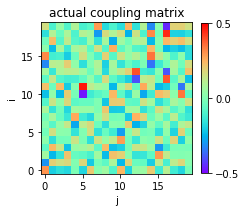

In [5]:
w0 = generate_coupling(n,m,g)

plt.figure(figsize=(3,3))
plt.title('actual coupling matrix')
plt.imshow(w0,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.clim(-0.5,0.5)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])
plt.show()

In [6]:
# 2018.10.27: generate sequences: time series
def generate_sequences(w,n,m,l): 
    #print(i1tab,i2tab)
    
    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    #print(s) 

    ntrial = 20

    for t in range(l):
        h = np.sum(s[t,:]*w[:,:],axis=1)
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]
    
            p1 = np.exp(h[i1:i2])
            p = p1/p1.sum()

            for itrial in range(ntrial):
                k = np.random.randint(0,m)
                if p[k] > np.random.rand():
                    s[t,i1:i2] = 0.
                    s[t,i1+k] = 1.
                break
    return s            

In [7]:
s = generate_sequences(w0,n,m,l) 

In [8]:
print(s[:10])

[[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]]


In [9]:
s_av = np.mean(s[:-1],axis=0)
ds = s[:-1] - s_av
c = np.cov(ds,rowvar=False,bias=True)
#print(c)

In [10]:
c_inv = linalg.pinv(c,rcond=1e-15)
#print(c_inv)

In [11]:
nm = n*m
wini = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
#print(w)

nloop = 20
w_infer = np.zeros((nm,nm))

for i in range(n):
    print(i)
    i1,i2 = i1tab[i],i2tab[i]
    #s1 = np.copy(s[1:,i1:i2])

    w = wini[i1:i2,:]
    
    for iloop in range(nloop):
        h = np.dot(s[:-1],w.T)
        
        p = np.exp(h)
        p_sum = p.sum(axis=1)
        
        for k in range(m):
            p[:,k] = p[:,k]/p_sum[:]

        h += s[1:,i1:i2] - p

        cost = ((s[1:,i1:i2]-p)**2).mean(axis=0)
        print(i,iloop,cost)

        h_av = h.mean(axis=0)
        dh = h - h_av

        dhds = dh[:,:,np.newaxis]*ds[:,np.newaxis,:]
        dhds_av = dhds.mean(axis=0)

        w = np.dot(dhds_av,c_inv)
        #w = w - w.mean(axis=0)    
    w_infer[i1:i2,:] = w        

0
(0, 0, array([0.28375456, 0.28375456]))
(0, 1, array([0.2609701, 0.2609701]))
(0, 2, array([0.25177707, 0.25177707]))
(0, 3, array([0.24891104, 0.24891104]))
(0, 4, array([0.24813747, 0.24813747]))
(0, 5, array([0.24793885, 0.24793885]))
(0, 6, array([0.24788883, 0.24788883]))
(0, 7, array([0.24787642, 0.24787642]))
(0, 8, array([0.24787341, 0.24787341]))
(0, 9, array([0.24787271, 0.24787271]))
(0, 10, array([0.24787256, 0.24787256]))
(0, 11, array([0.24787254, 0.24787254]))
(0, 12, array([0.24787254, 0.24787254]))
(0, 13, array([0.24787255, 0.24787255]))
(0, 14, array([0.24787255, 0.24787255]))
(0, 15, array([0.24787255, 0.24787255]))
(0, 16, array([0.24787255, 0.24787255]))
(0, 17, array([0.24787255, 0.24787255]))
(0, 18, array([0.24787255, 0.24787255]))
(0, 19, array([0.24787255, 0.24787255]))
1
(1, 0, array([0.27555738, 0.27555738]))
(1, 1, array([0.2562023, 0.2562023]))
(1, 2, array([0.25016966, 0.25016966]))
(1, 3, array([0.24855861, 0.24855861]))
(1, 4, array([0.24816915, 0.24

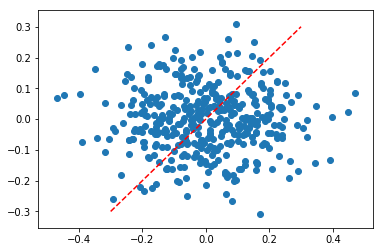

In [12]:
plt.scatter(w0,w_infer)
plt.plot([-0.3,0.3],[-0.3,0.3],'r--')